## Concurrency & Async Programming

### working with:
    multi threading
    multi processing
    async

Parallelism - processing multiple things at the same time.  True parallelism requires multiple processors (or cores)

Concurrency - handling multiple things at the same time which may or may not be actually running in the processor at the same time (such as network requests)

Parallelism requires concurrency but concurrency need not be in parallel

### Concurrency:  Having differenct code running at the same time
### Asynchrony: The occurrency of events indipendent of the main program flow and ways to deal with such events

## Types of Concurrency
####    Multithreading
            Multiple code paths sharing memory - one Python interpreter, one set of Python objects
####    Multiprocessing
            Multiple code paths with separate memory space - completely separate Python interpreter
####    Asyncronous programming
            Multiple 'jobs' run at 'arbitrary' times - but usually in one thread, i.e. only one code path, one interpreter

## Other Options:
### Micro-threads implemented via coroutines and a scheduler
        A coroutine is a generalization of a subroutine which allows multiple entry poiints for suspending and resuming execution.
        Coroutine based solutions follow a cooperative multitasking model

## Threads:
Threads are lightweight processes run in the address space of an OS process.  Threads can not gain the performance advantage of multiple processors due to the Global Interpreter Lock (GIL).  However the GIL is released during IO allowing IO bound processes to benefit from threading.

## Processes:
A process contains all the instructions and data required to execute independently so processes do NOT share data.  Multiple processes use to speed up CPU bound operations.  

Communication between processes can be achieved via:
    - multiprocessing.Queue
    - multiprocessing.Pipe
    - regular IPC(inter-process communication) must be pickleable

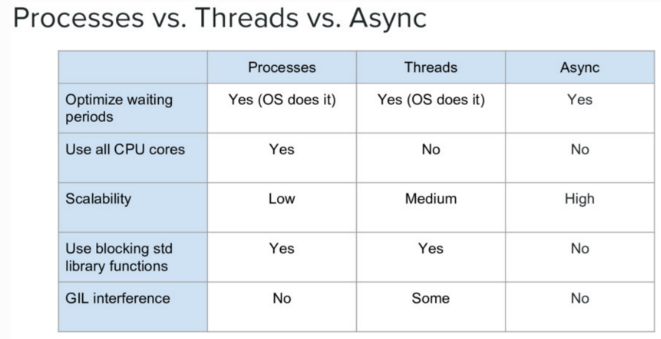

### Parallel execution example

In [ ]:
def f(x):
    return x**2

def integrate(f, a, b, N):
    s = 0
    dx = (b-a)/N
    for i in xrange(N):
        s += f(a+i*dx)
    return s * dx

#### we can do better than this
- break down the problem into parallelizable chunks, then add the results together

In [ ]:
def f(x):
    return x**2


def integrate(f, a, b, N):
    s = 0
    dx = (b - a) / N
    for i in range(N):
        s += f(a + i * dx)
    return s * dx


def integrate_f_with_functional_tools(f, a, b, N):
    dx = (b - a) / N
    return sum(map(f, ((a + y * dx) for y in range(N)))) * dx


# imported here so the rest of the code can run without it
import numpy as np


def integrate_numpy(f, a, b, N):
    """
    numpy can be used to "vectorize" the problem

    f must be "numpy comaptible"

    """
    dx = (b - a) / N
    i = np.arange(N)
    s = np.sum(f(a + (i * dx)))
    return s * dx


### Example of how to start a thread

In [ ]:
import sys
import threading
import time

def func():
    for i in range(5):
        print("hello from thread %s" % threading.current_thread().name)
        time.sleep(1)

threads = []
for i in range(3):
    thread = threading.Thread(target=func, args=())
    thread.start()
    threads.append(thread)

### Example of how to use threading in a class

In [ ]:
import threading

class MyThread(threading.Thread):

    def run(self):
        print("hello from %s" % threading.current_thread().name)

thread = MyThread()
thread.start()

### Example of how to use Mutex locks to prevent race condition

In [ ]:
x = 0
x_lock = threading.Lock()

# Example critical section
with x_lock:
    # statements using x

### Example of how to use RLock to prevent race condition

In [ ]:
import threading
import time

lock = threading.Lock()

def f():
    lock.acquire()
    print("%s got lock" % threading.current_thread().name)
    time.sleep(1)
    lock.release()

threading.Thread(target=f).start()
threading.Thread(target=f).start()
threading.Thread(target=f).start()

### Example of Nonblocking locking

In [ ]:
# .acquire() will return True if it successfully acquires a lock
# Its first argument is a boolean which specifies whether a lock should block or not.  The default is True

import threading
lock = threading.Lock()
lock.acquire()
if not lock.acquire(False):
    print("couldn't get lock")
lock.release()
if lock.acquire(False):
    print("got lock")

### Reentrant Lock - threading.RLock
Useful for recursive algorithms
A reentrant lock can be acquired multiple times by the same thread
Lock.release() must be called the same number of times as Lock.acquire() by a thread

### The Queue module allows a thread safe way of storing results from multiple threads of execution.
### Example:

In [ ]:
from queue import Queue
q = Queue(maxsize=10)
q.put(37337)
block = True
timeout = 2
print(q.get(block, timeout))

#### Common use: producer/consumer of patterns

In [ ]:
from queue import Queue
data_q = Queue()

Producer thread:
for item in produce_items():
    data_q.put(item)

Consumer thread:
while True:
    item = q.get()
    consume_item(item)

### Threading example with a queue

In [ ]:
#!/usr/bin/env python

import threading
import queue

# from integrate.integrate import integrate, f
from integrate import f, integrate_numpy as integrate
from decorators import timer


@timer
def threading_integrate(f, a, b, N, thread_count=2):
    """break work into N chunks"""
    N_chunk = int(float(N) / thread_count)
    dx = float(b - a) / thread_count

    results = queue.Queue()

    def worker(*args):
        results.put(integrate(*args))

    for i in range(thread_count):
        x0 = dx * i
        x1 = x0 + dx
        thread = threading.Thread(target=worker, args=(f, x0, x1, N_chunk))
        thread.start()
        print("Thread %s started" % thread.name)

    return sum((results.get() for i in range(thread_count)))


if __name__ == "__main__":

    # parameters of the integration
    a = 0.0
    b = 10.0
    N = 10**8
    thread_count = 8

    print("Numerical solution with N=%(N)d : %(x)f" %
          {'N': N, 'x': threading_integrate(f, a, b, N, thread_count=thread_count)})